[Book](https://otexts.com/)

# Holt-Winters Methods

Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    
<h3>For Further Reading:</h3>
<tt>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm'>NIST/SEMATECH e-Handbook of Statistical Methods</a></strong>&nbsp;&nbsp;<font color=black>What is Exponential Smoothing?</font></tt></div>

### Perform standard imports and load the dataset
For these examples we'll continue to use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [70]:
import pandas as pd
import numpy as np
%matplotlib inline

In [85]:
import pathlib
path = pathlib.Path(r"C:\Users\saurabhkumar9\15. TimeSeries\Data")

df = pd.read_csv(path/'airline_passengers.csv',index_col='Month',parse_dates=True)

In [78]:
df.dropna(inplace=True)

In [73]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

### Setting a DatetimeIndex Frequency
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [86]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [61]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


___
## Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [87]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

___
## Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

* **Additive Trend:** Double Exponential Smoothing with a linear trend.
* **Multiplicative Trend**: Double Exponential Smoothing with an exponential trend.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require **damping** that reduces the size of the trend over future periods until it reaches a flat line.

Brlow parameters to be tuned:
* **trend:** The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
* **damped:** Whether or not the trend component should be damped, either True or False.
* **seasonal:** The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
* **seasonal_periods:** The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['Thousands of Passengers'] = df['Thousands of Passengers'].astype(np.double)

df['DESadd12']= ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112.0,112.000000,112.000000,114.237762
1949-02-01,118.0,112.923077,112.923077,120.237762
1949-03-01,132.0,115.857988,115.857988,134.237762
1949-04-01,129.0,117.879836,117.879836,131.237762
1949-05-01,121.0,118.359861,118.359861,123.237762


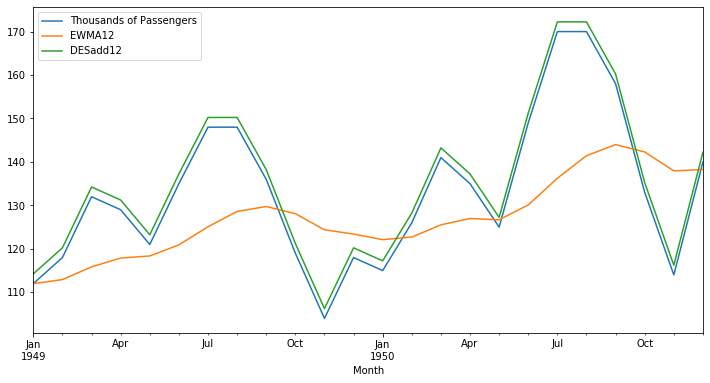

In [89]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [90]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112.0,112.000000,112.000000,114.237762,112.049247
1949-02-01,118.0,112.923077,112.923077,120.237762,118.051885
1949-03-01,132.0,115.857988,115.857988,134.237762,132.058041
1949-04-01,129.0,117.879836,117.879836,131.237762,129.056722
1949-05-01,121.0,118.359861,118.359861,123.237762,121.053204


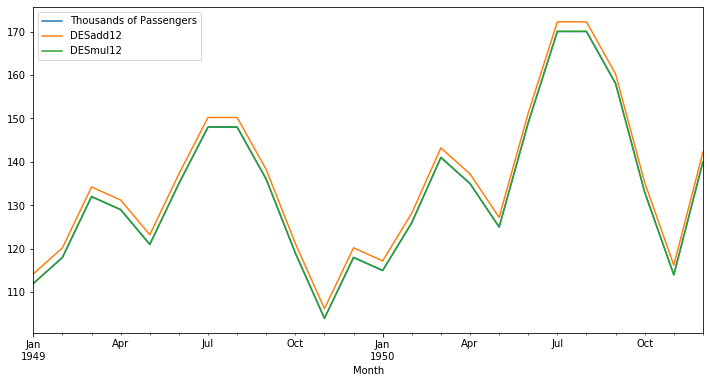

In [91]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

___
## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [93]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112.0,112.000000,112.000000,114.237762,112.049247,113.081288
1949-02-01,118.0,112.923077,112.923077,120.237762,118.051885,120.550753
1949-03-01,132.0,115.857988,115.857988,134.237762,132.058041,135.527339
1949-04-01,129.0,117.879836,117.879836,131.237762,129.056722,133.155076
1949-05-01,121.0,118.359861,118.359861,123.237762,121.053204,125.656129


In [94]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112.0,112.000000,112.000000,114.237762,112.049247,113.081288,111.608110
1949-02-01,118.0,112.923077,112.923077,120.237762,118.051885,120.550753,118.853687
1949-03-01,132.0,115.857988,115.857988,134.237762,132.058041,135.527339,133.343675
1949-04-01,129.0,117.879836,117.879836,131.237762,129.056722,133.155076,127.912641
1949-05-01,121.0,118.359861,118.359861,123.237762,121.053204,125.656129,120.991626


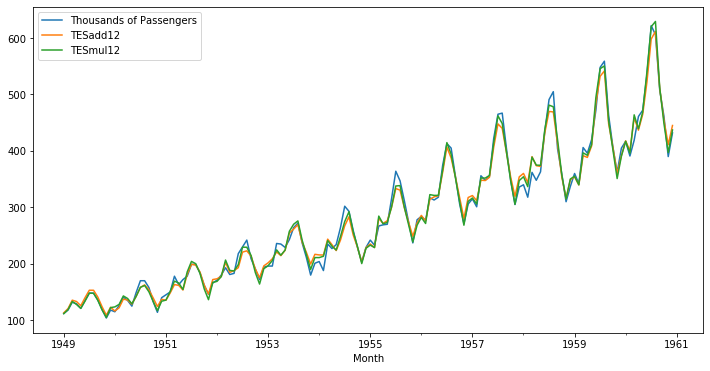

In [96]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(enable=True, axis='both', tight=None);

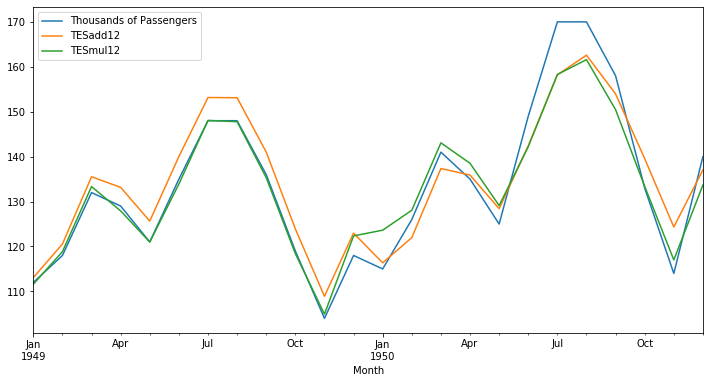

In [97]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - <em>forecasting</em>. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

But first, we'll work out some time series exercises before moving on to forecasting.

The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series. With the additive method, the seasonal component is expressed in absolute terms in the scale of the observed series, and in the level equation the series is seasonally adjusted by subtracting the seasonal component. Within each year, the seasonal component will add up to approximately zero. With the multiplicative method, the seasonal component is expressed in relative terms (percentages), and the series is seasonally adjusted by dividing through by the seasonal component. Within each year, the seasonal component will sum up to approximately m.